# Multivariate Particle Swarms for ANN learning/fitting

Before stating in Colab, you have to upload required files like noisy_xor.csv to your google drive, and also run the following code to mount your drive to Colab.

In [ ]:
#Mount personal drive and move into main directory
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('drive')
os.chdir('MyDrive')
os.chdir('AI_for_IA_2023/Assignment5')
os.listdir()  #list the files of the folder from where Colab will read and write files


Mounted at /content/drive


['TASK_B_PSO_multivariate_for_ANN_v230925.ipynb',
 'assignment_pso.py',
 'noisy_xor.csv',
 '__pycache__',
 'animation_demo_example.mp4']

### Import required packages and tools

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

### Define the Pyton classes Particle and Swarm

In [ ]:
# Define the Class Particle

class Particle():
    # Diff from 1D A& 2D PSO:
    # - Specify number of dim the space / input to obj function.
    # - Same search space range for all dim
    # - v_max specifies magnitude
    # - Include inertia term.
    # - Particle position is not a scaler (1d) but a vector w. size = dim of obj function input.
    # - x is now an ndarray
    # - Particle velocity is not a scalzr, but a vector v. size = dim of obj function input.

    def __init__(self, search_min, search_max, v_max, particle_id, obj_dim, objective_function, c1, c2, inertia):

        self.id = particle_id
        self.c1 = c1
        self.c2 = c2
        self.inertia = inertia

        self.obj_dim =  obj_dim

        self.search_min = search_min
        self.search_max = search_max

        self.v_max = v_max

        self.objective_function = objective_function

        # Specify random pos  x
        self.x = np.random.uniform(low = search_min, high=search_max, size = obj_dim)

        # Evaluate obj functon at current position
        self.fx = self.objective_function(self.x)

        # init. personal best position of particle, just init x for now.
        self.personal_best_x = self.x

        # init. personal best fx of particle in the begining.
        self.personal_best_fx = self.fx

        # Init particle velocity
        self.v_next = 0.01*np.random.randn(obj_dim)

        # trajectory not needed -> not going to vizualize anything.


    def step(self, global_best_x):
        # update v_next : DO

        r_cognitive = np.random.uniform(size=self.obj_dim)

        r_social = np.random.uniform(size=self.obj_dim)

        cognitive_influence_x = self.c1 * r_cognitive * (self.personal_best_x - self.x)
        social_influence_x = self.c2 * r_social * (global_best_x - self.x)

        self.v_next = self.inertia*self.v_next + cognitive_influence_x + social_influence_x


        # Cap v_next if it gets to big:  DO
        # In multi-dim -> cap per dim. / element.
        for i in range(self.obj_dim):
            if np.abs(self.v_next[i]) > self.v_max:
                self.v_next[i] = np.sign(self.v_next[i]) * self.v_max

        # update x : DO
        self.x = self.x + self.v_next

        # cap at max search boundray
        for i in range(self.obj_dim):
            if self.x[i] > self.search_max:
                self.x[i] = self.search_max
                #self.x[i] = np.random.uniform(low = self.search_min, high= self.search_max, size=1) # DO: TELL

        # cap at min search boundray
        for i in range(self.obj_dim):
            if self.x[i] < self.search_min:
                self.x[i] = self.search_min
                #self.x[i] = np.random.uniform(low = self.search_min, high= self.search_max, size = 1) # DO: TELL

        # evaluate f(x)
        self.fx = self.objective_function(self.x)

        # update personal_best_x if case
        if self.fx < self.personal_best_fx:
            self.personal_best_fx = self.fx
            self.personal_best_x = self.x

    def get_particle_info_array(self): # DO: CAUTION  FOR MULTI-DIM
        # Return dictionary
        # [x, f(x), v_next, x_personal_best, f(x_personal_best)]

        return {'id':self.id,
                'x':self.x,
                'fx':self.fx,
                'v_next':self.v_next,
                'personal_best_x':self.personal_best_x,
                'personal_best_fx':self.personal_best_fx}



In [ ]:
# Define the Class Swarm

class Swarm():


    def __init__(self, objective_function, obj_dim, N_particles,
                 search_min, search_max, v_max, c1, c2, inertia):

        self.objective_function = objective_function
        self.nr_particles = N_particles
        self.obj_dim = obj_dim

        self.search_min = search_min
        self.search_max = search_min


        self.v_max = v_max

        self.c1 = c1
        self.c2 = c2
        self.inertia = inertia

        self.step_i = 0 # internal steo counter

        # Init N paritcles in swarm
        self.swarm = []
        for i in range(self.nr_particles):
            p = Particle(search_min = search_min,
                         search_max = search_max,
                         v_max=v_max,
                         particle_id=i,
                         objective_function=self.objective_function,
                         obj_dim = self.obj_dim,
                         c1=c1,
                         c2=c2,
                         inertia=self.inertia)
            self.swarm.append(p)

        self.global_best_x, self.global_best_fx = self.get_current_best_x_and_fx()


        print(f'Current global best x: {self.global_best_x},\n Current global best f(x): {self.global_best_fx}')



    def get_current_best_x_and_fx(self):
        '''return the global best position x_best and the value of the objective function value at posistion x_best '''

        current_best_swarm_fx = np.inf
        current_best_particle_index = 0

        for particle in self.swarm:
            if particle.fx < current_best_swarm_fx:
                current_best_swarm_fx = particle.fx
                current_best_swarm_x = particle.x



        return current_best_swarm_x, current_best_swarm_fx


    def step(self):

        # for all particles take one step
        for particle in self.swarm:
            particle.step(global_best_x=self.global_best_x)

        # get and set current best and logic it
        current_best_x, current_best_fx = self.get_current_best_x_and_fx()


        if current_best_fx < self.global_best_fx:
            self.global_best_x = current_best_x
            self.global_best_fx = current_best_fx
            print(f'New Global Best has been achieved in iteration {self.step_i} reaching function value f(x) = {self.global_best_fx}')


        self.step_i +=1


    def run(self, nr_steps):

        for i in range(nr_steps):
            self.step()

        print(f'Current global best x: {self.global_best_x},\n Current global best f(x): {self.global_best_fx}')

        return self.global_best_x,  self.global_best_fx


Randomly generate and univariate function to minimize

###  Import data from noisy_xor.csv

In [ ]:
# Read data from CSV to Numpy
D_np_2D_array = np.genfromtxt('noisy_xor.csv', delimiter=',')


#  *****************  TRAINING DATA: GLOBAL VARIABLES  *************************
# Extract input and target values
X_np_2D_array_examples_as_rows_GLOBAL = D_np_2D_array [:, :2]
targets_y_np_2D_column_array_GLOBAL = D_np_2D_array [:, 2].reshape(-1,1)
# ******************************************************************************

In [ ]:
print('targets_y_np_2D_column_array_GLOBAL.shape=',targets_y_np_2D_column_array_GLOBAL.shape)
print('X_np_2D_array_examples_as_rows_GLOBAL.shape=',X_np_2D_array_examples_as_rows_GLOBAL.shape)

targets_y_np_2D_column_array_GLOBAL.shape= (47, 1)
X_np_2D_array_examples_as_rows_GLOBAL.shape= (47, 2)


### Define the cost function to be the number of classification errors

In [ ]:
def cost_function_no_of_errors(y_preds_np_2D_column_array, y_true_np_2D_column_array):
    N = y_preds_np_2D_column_array.size #number of examples
    no_of_errors = N - np.sum(np.equal(np.rint(y_preds_np_2D_column_array),np.rint(targets_y_np_2D_column_array_GLOBAL)))
    return no_of_errors

### Define the logistic funtion

In [ ]:
def logistic(x):
    return 1/(1+np.exp(-x))

### Define two ANN network predictors with structures 2-2-1 and 2-10-5-1

In [ ]:

def ann_2_2_1_prediction(X_as_np_2D_array_examples_as_rows, np_1D_array_with_parameters_of_ANN):

    #Extract W1, b1, w2, b2 for the ANN with structure 2-2-1
    W1_as_np_2D_array = np_1D_array_with_parameters_of_ANN[0:4].reshape(2,2)
    b1_as_np_2D_column = np_1D_array_with_parameters_of_ANN[4:6].reshape(2,1)
    w2_as_np_2D_row = np_1D_array_with_parameters_of_ANN[6:8].reshape(1,2)
    b2_as_1D_np_array = np_1D_array_with_parameters_of_ANN[8]

    #Calculate hidden layer output using matrix-vector multiplication
    V_examples_as_cols = np.matmul(W1_as_np_2D_array,np.transpose(X_as_np_2D_array_examples_as_rows))+b1_as_np_2D_column
    Z_examples_as_cols = logistic(V_examples_as_cols)

    #Calculate network output using matrix-vector multiplication
    v_preds_as_np_2D_row = np.matmul(w2_as_np_2D_row,Z_examples_as_cols)+b2_as_1D_np_array
    y_preds_as_np_2D_row = logistic(v_preds_as_np_2D_row)
    y_preds_as_np_2D_colum = np.transpose(y_preds_as_np_2D_row)

    return y_preds_as_np_2D_colum

In [ ]:
def ann_2_10_5_1_prediction(X_as_np_2D_array_examples_as_rows, np_1D_array_with_parameters_of_ANN):

    # ANN: 2-10-5-1
    # W1: 10x2
    # b1 = 10
    # W2: 5x10
    # b2 = 5
    # w3: 1x5
    # b3 = 1

    #Extract W1, b1, W2, b2 and w3 and b3 for the ANN with structure 2-10-5-1
    W1_as_np_2D_array = np_1D_array_with_parameters_of_ANN[0:20].reshape(10,2)
    b1_as_np_2D_column = np_1D_array_with_parameters_of_ANN[20:30].reshape(10,1)
    W2_as_np_2D_array = np_1D_array_with_parameters_of_ANN[30:80].reshape(5,10)
    b2_as_np_2D_column = np_1D_array_with_parameters_of_ANN[80:85].reshape(5,1)
    w3_as_np_2D_row = np_1D_array_with_parameters_of_ANN[85:90].reshape(1,5)
    b3_as_1D_np_array = np_1D_array_with_parameters_of_ANN[90]

    #Calculate first hidden layer output
    V1_examples_as_cols = np.matmul(W1_as_np_2D_array,np.transpose(X_as_np_2D_array_examples_as_rows)) + b1_as_np_2D_column
    Z1_examples_as_cols = logistic(V1_examples_as_cols)

    #Calculate second hidden layer output
    V2_examples_as_cols = np.matmul(W2_as_np_2D_array,Z1_examples_as_cols)+b2_as_np_2D_column
    Z2_examples_as_cols = logistic(V2_examples_as_cols)

    #Calculate network output
    v_preds_as_row = np.matmul(w3_as_np_2D_row,Z2_examples_as_cols)+b3_as_1D_np_array
    y_preds_as_row = logistic(v_preds_as_row)
    y_preds_as_np_2D_colum = np.transpose(y_preds_as_row)

    return y_preds_as_np_2D_colum

### Define the two objective functions corresponding to the ANNs with structure 2-2-1 and 2-10-5-1

In [ ]:
def no_of_errors_objective_function_2_2_1_ANN(np_1D_array_with_parameters_of_ANN):
    y_preds_as_np_2D_colum = ann_2_2_1_prediction(X_np_2D_array_examples_as_rows_GLOBAL, np_1D_array_with_parameters_of_ANN)
    no_of_errors = cost_function_no_of_errors(y_preds_as_np_2D_colum, targets_y_np_2D_column_array_GLOBAL)
    return no_of_errors


def no_of_errors_objective_function_2_10_5_1_ANN(np_1D_array_with_parameters_of_ANN):
    y_preds_as_np_2D_colum = ann_2_10_5_1_prediction(X_np_2D_array_examples_as_rows_GLOBAL, np_1D_array_with_parameters_of_ANN)
    no_of_errors = cost_function_no_of_errors(y_preds_as_np_2D_colum, targets_y_np_2D_column_array_GLOBAL)
    return no_of_errors

### EXAMPLE 1: Training of ANN with structure 2-2-1

In [ ]:
# Test swarm construction using 2-2-1 network with 9 parameters
no_of_ANN_parameters = 9

my_pso_for_2_2_1_ANN_no_of_errors = Swarm(objective_function = no_of_errors_objective_function_2_2_1_ANN,
                      obj_dim = no_of_ANN_parameters,
                      N_particles = 100,
                      search_min = -10.0,
                      search_max = 10.0,
                      v_max = 1,
                      c1 = 2.0,
                      c2 = 1.0,
                      inertia = 1)

Current global best x: [-3.50911826 -2.92595043  5.30256037  6.90946732 -1.88119908 -0.33223823
 -5.60165592  7.76324408 -6.18961238],
 Current global best f(x): 10


In [ ]:
#Run 1000 iterations
pso_best_paramvector_for_2_2_1_ANN, pso_no_of_errors_for_2_2_1_ANN = my_pso_for_2_2_1_ANN_no_of_errors.run(nr_steps=1000)


New Global Best has been achieved in iteration 1 reaching function value f(x) = 9
New Global Best has been achieved in iteration 2 reaching function value f(x) = 8
New Global Best has been achieved in iteration 18 reaching function value f(x) = 4
New Global Best has been achieved in iteration 38 reaching function value f(x) = 2
New Global Best has been achieved in iteration 48 reaching function value f(x) = 1
New Global Best has been achieved in iteration 93 reaching function value f(x) = 0
Current global best x: [ 2.25985653 -2.13681159  3.71634196 -4.81556911  1.23995853  3.21424792
  4.30315108 -4.12176179  0.13550535],
 Current global best f(x): 0


### EXAMPLE 2: Training of ANN with structure 2-10-5-1

In [ ]:
# Test swarm construction using 2-10-5-1 network with 9 parameters
no_of_ANN_parameters = 91
search_min = -10.0
search_max = 10.0


my_pso_for_2_10_5_1_ANN_no_of_errors = Swarm(objective_function = no_of_errors_objective_function_2_10_5_1_ANN,
                      obj_dim = no_of_ANN_parameters,
                      N_particles = 100,
                      search_min = search_min,
                      search_max = search_max,
                      v_max = 1,
                      c1 = 2.0,
                      c2 = 1.0,
                      inertia = 1)

Current global best x: [-8.50097405  1.53831804 -0.60942885 -5.75805453  3.64824005 -4.30661742
 -8.05757275  3.42096344 -1.5038742   1.96443854 -2.47130411 -0.58431459
  0.51289594  2.47286501  5.93307931 -2.16196803 -0.51958647 -4.9737361
 -1.03358806 -7.55086489 -2.75426893  2.99203807  7.87879986 -1.22561086
 -8.30105382 -2.36797853 -6.23615008  8.81030465 -9.4168424   0.50625785
  9.78787463 -4.36988262 -4.68975888  8.27166833 -8.39221547 -9.00156805
  0.168523    3.15928361  2.41173466  4.77342135  6.48761273 -2.18797803
  5.38800368  2.30790319 -4.61889394 -0.54494817  6.53177481 -8.02920068
 -4.32884168  5.02069547 -9.62841738  3.70065609  4.53840705  7.87637408
  7.15780555 -1.22862388  7.85745174  7.34839821 -1.86208883 -7.05020808
  3.22975533 -8.66100897  5.72231634 -0.63601313  7.59555504  9.98516904
 -6.95576817 -9.70246129 -0.55617889  8.33809263  4.55309731  2.25796592
 -3.71022583  0.62645259  4.92932997 -6.8699264  -6.29674656  5.23067129
 -2.98882803  8.85764799  2.0

In [ ]:
#Run 100 steps
pso_best_paramvector_for_2_10_5_1_ANN, pso_no_of_errors_for_2_10_5_1_ANN =my_pso_for_2_10_5_1_ANN_no_of_errors.run(nr_steps=100)

New Global Best has been achieved in iteration 0 reaching function value f(x) = 9
New Global Best has been achieved in iteration 2 reaching function value f(x) = 7
New Global Best has been achieved in iteration 3 reaching function value f(x) = 3
New Global Best has been achieved in iteration 8 reaching function value f(x) = 2
New Global Best has been achieved in iteration 12 reaching function value f(x) = 1
New Global Best has been achieved in iteration 16 reaching function value f(x) = 0
Current global best x: [ -5.3259735   -8.23041827  -0.03218073  -3.82932509   5.33805219
  -5.03714779  -2.92007868   1.44252263   4.81164875  -4.91438203
   1.69620535   3.1666956   -0.24432339   4.88156294   3.63576248
  -0.01395329  -5.23827489  -3.20015207  -3.35247558   4.05473616
  -1.195243     4.11391917  -2.89922725  -2.33145813   2.73872174
  -4.83480878  -4.58061597   4.43645338  -7.38851183  -5.00151164
  -0.65559249   3.51571624   6.22645      5.4564016   -6.96975303
   2.66264136  -0.480

### Make predictions (blue) using the best network found and compare with the desired outputs (orange)

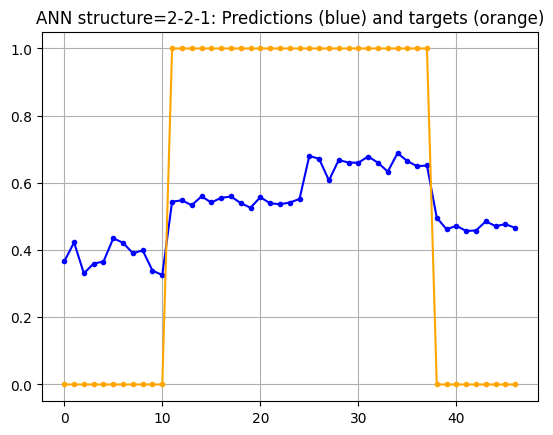

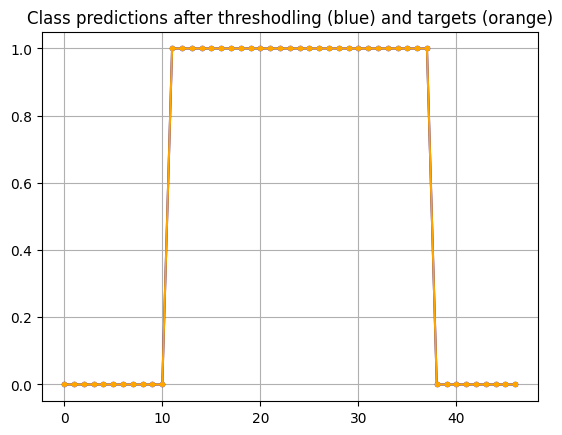

In [ ]:
current_ANN_structure = '2-2-1'
#current_ANN_structure='2-10-5-1'

if current_ANN_structure == '2-2-1':
    y_pred_as_np_2D_colum = ann_2_2_1_prediction(X_np_2D_array_examples_as_rows_GLOBAL, pso_best_paramvector_for_2_2_1_ANN)
else:
    y_pred_as_np_2D_colum = ann_2_10_5_1_prediction(X_np_2D_array_examples_as_rows_GLOBAL, pso_best_paramvector_for_2_10_5_1_ANN)


plt.figure()
plt.subplot(111)
plt.plot(y_pred_as_np_2D_colum,marker='.',color='blue')
plt.plot(targets_y_np_2D_column_array_GLOBAL,marker='.',color='orange')
plt.title('ANN structure='+current_ANN_structure +': Predictions (blue) and targets (orange)')
plt.grid()

plt.figure()
plt.subplot(111)
plt.plot(np.rint(y_pred_as_np_2D_colum),marker='.',color='blue')
plt.plot(targets_y_np_2D_column_array_GLOBAL,marker='.',color='orange')
plt.title('Class predictions after threshodling (blue) and targets (orange)')
plt.grid()

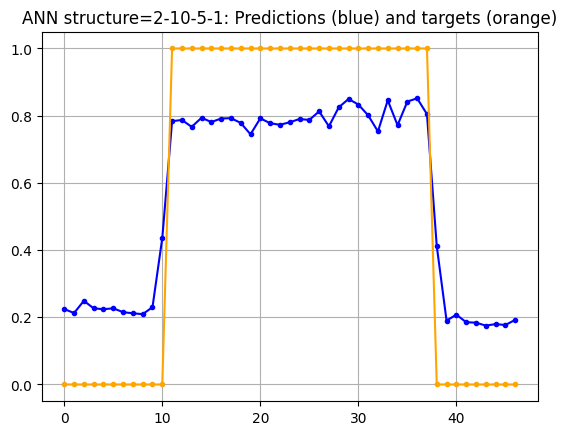

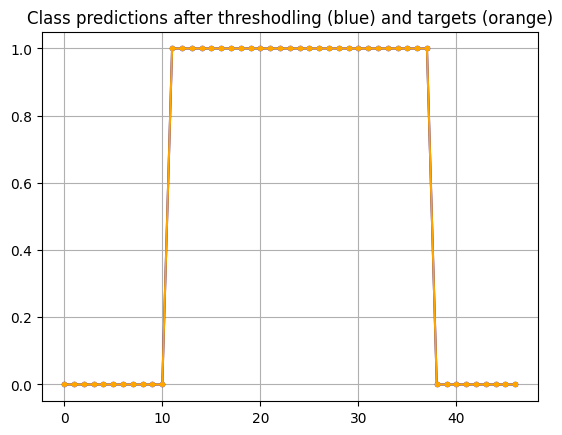

In [ ]:
current_ANN_structure='2-10-5-1'

if current_ANN_structure == '2-2-1':
    y_pred_as_np_2D_colum = ann_2_2_1_prediction(X_np_2D_array_examples_as_rows_GLOBAL, pso_best_paramvector_for_2_2_1_ANN)
else:
    y_pred_as_np_2D_colum = ann_2_10_5_1_prediction(X_np_2D_array_examples_as_rows_GLOBAL, pso_best_paramvector_for_2_10_5_1_ANN)


plt.figure()
plt.subplot(111)
plt.plot(y_pred_as_np_2D_colum,marker='.',color='blue')
plt.plot(targets_y_np_2D_column_array_GLOBAL,marker='.',color='orange')
plt.title('ANN structure='+current_ANN_structure +': Predictions (blue) and targets (orange)')
plt.grid()

plt.figure()
plt.subplot(111)
plt.plot(np.rint(y_pred_as_np_2D_colum),marker='.',color='blue')
plt.plot(targets_y_np_2D_column_array_GLOBAL,marker='.',color='orange')
plt.title('Class predictions after threshodling (blue) and targets (orange)')
plt.grid()

### Evaluate the best trained network across a grid to produce heatmap and 3D surface

In [ ]:
#DETERMINE THE NETWORK RESPONSE Y_pred ACROSS THE INPUT SPACE OF INTEREST
x1_values = np.linspace(-0.5,1.5,150)
x2_values = np.linspace(-0.5,1.5,150)
Y_pred = np.empty((x1_values.size,x2_values.size))


if current_ANN_structure=='2-10-5-1':
    for i in range(x1_values.size):
        for j in range(x2_values.size):
            tmp_array = np.asarray([x1_values[i],x2_values[j]])
            X_as_np_2D_array_examples_as_rows = tmp_array.reshape(1,-1)
            y_pred_as_np_2D_colum = ann_2_2_1_prediction(X_as_np_2D_array_examples_as_rows, pso_best_paramvector_for_2_2_1_ANN)
            Y_pred[i,j] = y_pred_as_np_2D_colum[0]
else:
    for i in range(x1_values.size):
        for j in range(x2_values.size):
            tmp_array = np.asarray([x1_values[i],x2_values[j]])
            X_as_np_2D_array_examples_as_rows = tmp_array.reshape(1,-1)
            y_pred_as_np_2D_colum = ann_2_10_5_1_prediction(X_as_np_2D_array_examples_as_rows, pso_best_paramvector_for_2_10_5_1_ANN)
            Y_pred[i,j] = y_pred_as_np_2D_colum[0]



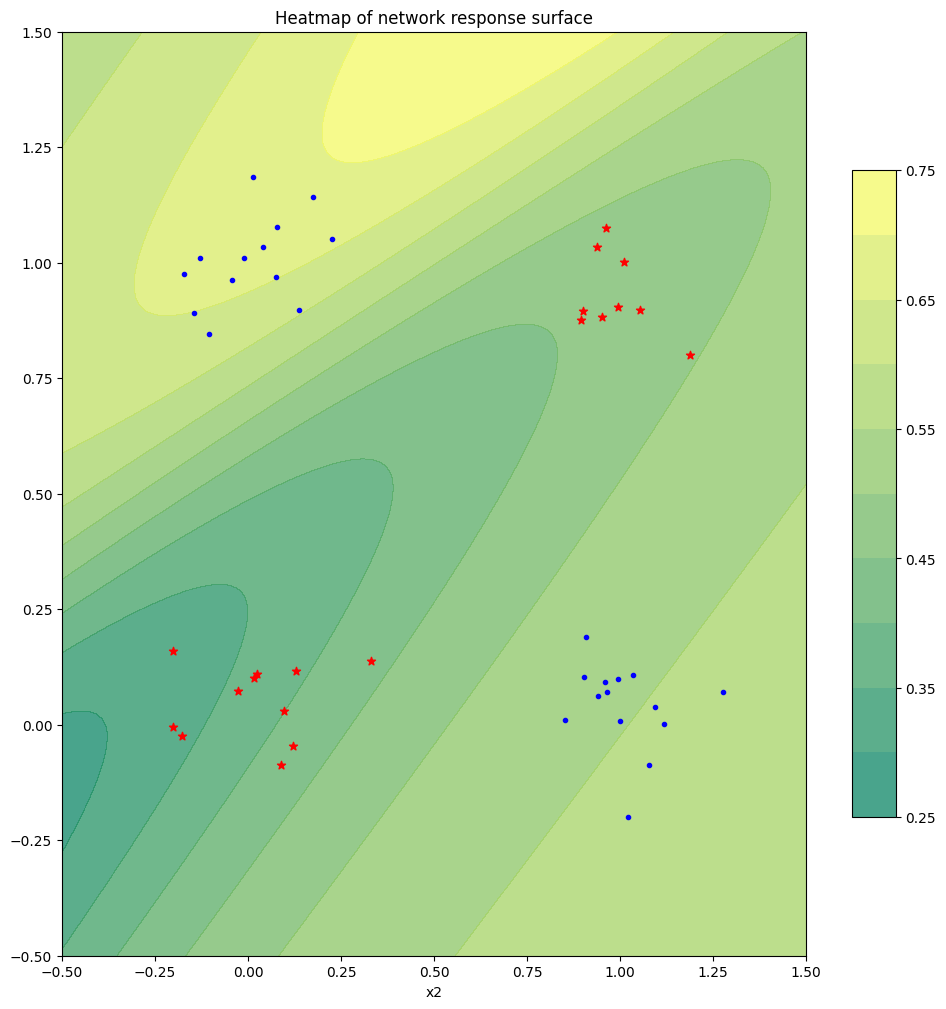

In [ ]:
#CREATE "HEATMAP" SHOWING THE NETWORK RESPONSES

fig, ax = plt.subplots(figsize=(12, 12))

no_of_contour_levels=9

X1, X2 = np.meshgrid(x1_values, x2_values)

c = plt.contourf(X2,X1,Y_pred,no_of_contour_levels, alpha=.75, cmap="summer")
plt.colorbar(shrink=0.7, aspect=15)

np.x1 = X_np_2D_array_examples_as_rows_GLOBAL[:,0]
np.x2 = X_np_2D_array_examples_as_rows_GLOBAL[:,1]
logical_blue = np.logical_not(targets_y_np_2D_column_array_GLOBAL==0)
logical_red = (targets_y_np_2D_column_array_GLOBAL==0)
logical_blue_1d = logical_blue.flatten()
logical_red_1d = logical_red.flatten()


logical_blue=np.logical_not(targets_y_np_2D_column_array_GLOBAL==0)
logical_red=(targets_y_np_2D_column_array_GLOBAL==0)
ax.scatter(np.x1[logical_blue_1d],np.x2[logical_blue_1d],marker='.',color='b')
ax.scatter(np.x1[logical_red_1d],np.x2[logical_red_1d],marker='*',color='r')

plt.title('Heatmap of network response surface')
plt.xlabel('x1')
plt.xlabel('x2')
plt.show();

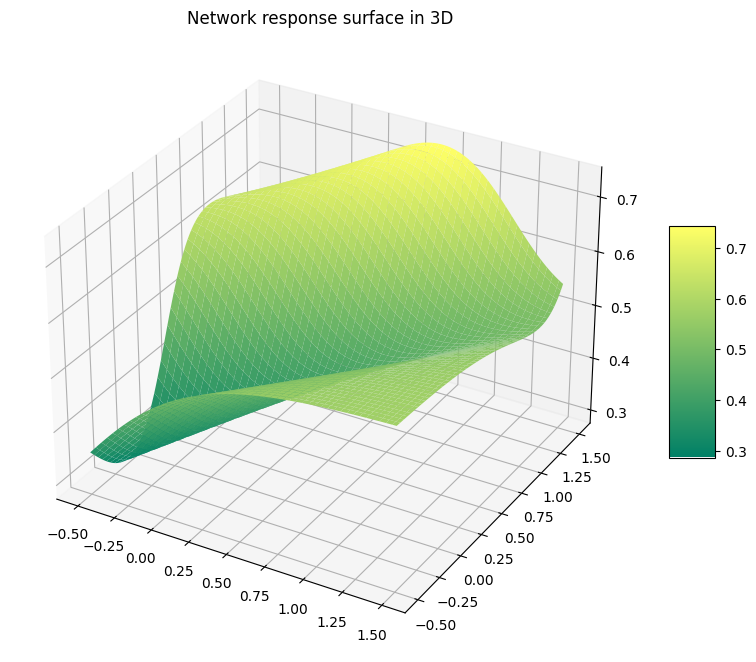

In [ ]:
fig=plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection='3d')
X1, X2 = np.meshgrid(x1_values, x2_values)
surf =ax.plot_surface(X2, X1, Y_pred,cmap="summer")
fig.colorbar(surf, shrink=0.3, aspect=5);
plt.title('Network response surface in 3D');

# Now what?:
Continue by answering the problems in the associated assignment document.